# Recommender Systems
- Author: Chris Hodapp
- Date: 2018-02-04
- Done as part of a [SharpestMinds](https://www.sharpestminds.com/) skills test

## TODO

- Intersperse SVD algorithm a bit better.
- Make at least an attempt at content-based

The aim of this notebook is to briefly explain *recommender systems*, show some specific examples of them, and to demonstrate simple implementations of them in Python/NumPy/Pandas.

Recommender systems are quite a broad subject on their own.  This notebook focuses on movie recommendations from explicit ratings. That is, it's focusing on the scenario in which:

- There are a large number of users and a large number of movies.
- Users have supplied ratings on certain movies.
- The movies are different for each user, and the vast majority of users have rated only a tiny fraction of the overall movies.

The goal is to make predictions based on this data, such as:

- How a given user will most likely rate specific movies they have not seen before
- What "new" movies a system might recommended to them

This uses the [movielens 100k](https://grouplens.org/datasets/movielens/100k/) dataset, (which you can download yourself, and should if you wish to run the code). It has 100,000 ratings total by 944 users on 1,683 different movies. As far as movie datasets go, it's fairly old (1998) and fairly small (the Netflix dataset from 10+ years ago has 1000 times as many ratings), but it's enough to work with. In any case, MovieLens has [newer and larger](https://grouplens.org/datasets/movielens/latest/) datasets too.

I refer several times in this notebook to the free textbook [Mining of Massive Datasets](http://www.mmds.org/) (hereafter, just "MMDS"), mostly to chapter 9, *Recommendation Systems*.  It's worth reading if you want to know more.

## Motivation

I try to clearly implement everything I talk about here, and be specific about the method. Some other work I read in this area had me rather frustrated with its tendency to completely ignore implementation details that are both critical and very difficult for an outsider (i.e. me) to articulate questions on, and this is something I try to avoid. I'd like for you to be able to execute it yourself, to build intuition on how the math works, to understand why the code implements the math as it does, and to have good starting points for further research.

In the Slope One explanation, this means I give perhaps a needless amount of detail behind the linear algebra implementation, but maybe some will find it valuable (besides just me when I try to read this code in 3 months).

## Organization

I start out by loading the movielens data (just the parts I need), exploring it briefly, and converting it to a form we need.

Following that, I start with a simple (but surprisingly effective) collaborative filtering model, Slope One Predictors.  I explain it, implement it with some linear algebra shortcuts, and run it on the data.

I go from here to a slightly more complicated method (the badly-named "SVD" algorithm) that is based on matrix completion using matrix decomposition. I explain this, implement it with gradient-descent, and run it on the data. I also use this as an opportunity to visualize a latent feature space that the model learns.

Near the end, I show how to run the same basic algorithms in [scikit-surprise](http://surpriselib.com/) rather than implement them by hand.

# Dependencies & Setup

Download [movielens 100k](https://grouplens.org/datasets/movielens/100k/) and uncompress it in the local directory. There should be a `ml-100k` folder.

For Python dependencies, everything I need is imported below: pandas, numpy, matplotlib, and scikit-learn.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection

# Loading data

I don't explain this in detail. This is just standard calls in [Pandas](https://pandas.pydata.org/) and little details that are boring but essential:

In [2]:
ml = pd.read_csv("ml-100k/u.data", sep="\t", header=None,
                 names=("user_id", "movie_id", "rating", "time"))
# Convert Unix seconds to a Pandas timestamp:
ml["time"] = pd.to_datetime(ml["time"], unit="s")

Below is just to inspect that data appears to be okay:

In [3]:
ml.describe()

,user_id,movie_id,rating
count,100000.00000,100000.000000,100000.000000
mean,462.48475,425.530130,3.529860
std,266.61442,330.798356,1.125674
min,1.00000,1.000000,1.000000
25%,254.00000,175.000000,3.000000
50%,447.00000,322.000000,4.000000
75%,682.00000,631.000000,4.000000
max,943.00000,1682.000000,5.000000


In [4]:
ml[:10]

,user_id,movie_id,rating,time
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16
5,298,474,4,1998-01-07 14:20:06
6,115,265,2,1997-12-03 17:51:28
7,253,465,5,1998-04-03 18:34:27
8,305,451,3,1998-02-01 09:20:17
9,6,86,3,1997-12-31 21:16:53


In [5]:
max_user  = int(ml["user_id"].max() + 1)
max_movie = int(ml["movie_id"].max() + 1)
max_user, max_movie, max_user * max_movie

(944, 1683, 1588752)

We have only about 6% of the possible ratings (e.g. every movie & every user):

In [6]:
100 * ml.shape[0] / (max_user * max_movie)

6.294248567429026

## Aggregation

This is partly just to explore the data a little, and partly because we need to aggregate some information to use in models later - like the number of ratings for each movie, and each movie's average rating.

The dataset includes a lot of per-movie information too, but we only bother with the title so far:

In [7]:
names = pd.read_csv(
    "ml-100k/u.item", sep="|", header=None,
    encoding = "ISO-8859-1", index_col=0,
    names=("movie_id", "movie_title"), usecols=[0,1])

In [8]:
movie_group = ml.groupby("movie_id")
movie_stats = names.\
    join(movie_group.size().rename("num_ratings")).\
    join(movie_group.mean()["rating"].rename("avg_rating"))

Sorting by number of ratings and taking the top 25, this looks pretty sensible for 1998:

In [9]:
movie_stats.sort_values("num_ratings", ascending=False)[:25]

,movie_title,num_ratings,avg_rating
movie_id,,,
50,Star Wars (1977),583,4.358491
258,Contact (1997),509,3.803536
100,Fargo (1996),508,4.155512
181,Return of the Jedi (1983),507,4.007890
294,Liar Liar (1997),485,3.156701
286,"English Patient, The (1996)",481,3.656965
288,Scream (1996),478,3.441423
1,Toy Story (1995),452,3.878319
300,Air Force One (1997),431,3.631090


# Utility Matrix

The notion of the *utility matrix* comes up in many methods as a way of
expressing the ratings data. For one thing, this opens up the data to an
array of linear algebra operations (such as matrix multiplication and
[SVD](https://en.wikipedia.org/wiki/Singular-value_decomposition)) that
are useful for transforming the data, meaningful for interpreting it,
very readily-available and optimized, and provide a common language for
discussing and analyzing what we are actually doing to the data.  (For some
examples of this, check out section 11.3.2 in [MMDS](http://www.mmds.org/).)

In a utility matrix, each row represents one user, each column represents
one item (a movie, in our case), and each element represents a user's
rating of an item.  If we have $n$ users and $m$ movies, then this a
$n \times m$ matrix $U$ for which $U_{k,i}$ is user $k$'s rating for
movie $i$ - assuming we've numbered our users and our movies.

Users have typically rated only a fraction of movies, and so most of
the elements of this matrix are unknown. Algorithms represent this
in different ways; the use of [sparse matrices](https://en.wikipedia.org/wiki/Sparse_matrix)
where a value of 0 signifies unknown information is common.

Some algorithms involve constructing the utility matrix explicitly and
doing matrix operations directly on it (the approach to Slope One that
we do later works this way). Other methods just use it as a method of
analyzing something from a linear algebra standpoint, but dispense with
the need for an explicit matrix within the algorithm (the "SVD" method
later does this).

In [10]:
ml_train, ml_test = sklearn.model_selection.train_test_split(ml, test_size=0.25, random_state=12345678)

We'll convert our data to a utility matrix below, which is pretty simple in NumPy:

In [11]:
def df2mat(df):
    m = np.zeros((max_user, max_movie))
    m[df["user_id"], df["movie_id"]] = df["rating"]
    return m, m > 0
ml_mat_train, ml_mask_train = df2mat(ml_train)
ml_mat_test,  ml_mask_test  = df2mat(ml_test)

We need a mask for some later steps, hence the m > 0 step; ratings go only from 1 to 5, so values of 0 are automatically unknown/missing data.

If this were an actual large amount of data, which a 944x1683 matrix doesn't really count as, you'd probably want [sparse matrices](https://docs.scipy.org/doc/scipy/reference/sparse.html) and to use 8-bit ints rather than 32-bit floats, for instance:

```python
ml_mat = scipy.sparse.coo_matrix(
    (ml["rating"], (ml["user_id"], ml["movie_id"])),
    shape=(max_user, max_movie),
    dtype=np.int8)
```

In [12]:
ml_mat_train

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  5.,  3., ...,  0.,  0.,  0.],
       [ 0.,  4.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  5.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  5., ...,  0.,  0.,  0.]])

In [13]:
ml_train[:10]

,user_id,movie_id,rating,time
58426,844,423,3,1997-10-20 21:26:02
24359,474,76,4,1998-02-19 22:16:13
20022,437,423,5,1997-11-21 19:39:56
19108,392,511,5,1998-03-27 22:49:05
56274,619,187,5,1998-01-28 02:19:52
76661,933,405,3,1997-09-22 14:39:17
52885,755,690,5,1997-12-19 22:12:54
43245,299,202,4,1998-03-10 03:42:05
61136,804,196,4,1997-11-13 17:22:32
35739,26,109,3,1998-03-31 20:43:07


Just to show that the matrix does in fact have the same data:

In [14]:
user_ids = list(ml_train.iloc[:10].user_id)
user_ids

[844, 474, 437, 392, 619, 933, 755, 299, 804, 26]

In [15]:
movie_ids = list(ml_train.iloc[:10].movie_id)
movie_ids

[423, 76, 423, 511, 187, 405, 690, 202, 196, 109]

In [16]:
ml_mat_train[user_ids, movie_ids]

array([ 3.,  4.,  5.,  5.,  5.,  3.,  5.,  4.,  4.,  3.])

In [17]:
list(ml_train.iloc[:10].rating)

[3, 4, 5, 5, 5, 3, 5, 4, 4, 3]

Okay, enough of that; we can begin with some actual predictions.

# Slope One Predictors

We'll begin with a method of predicting ratings that is wonderfully
simple to understand, equally simple to implement, very fast,
and surprisingly effective.  This method is described in the
paper [Slope One Predictors for Online Rating-Based Collaborative Filtering](https://arxiv.org/pdf/cs/0702144v1.pdf). They can be computed given
just some arithmetic over the dataset we just loaded.
Neither linear algebra nor calculus nor numerical
approximation is needed, while all three are needed for the
[next method](#"SVD"-algorithm).

I'll give a contrived example below to explain them.

Consider a user Bob.  Bob is enthusiastic, but has rather simple
tastes: he mostly just watches Clint Eastwood movies.  In fact, he's
watched and rated nearly all of them, and basically nothing else.

Now, suppose we want to predict how much Bob will like something
completely different and unheard of (to him at least), like... I don't
know... *Citizen Kane*.

Here's Slope One in a nutshell:

1. First, find the users who rated both *Citizen Kane* and any of
   the Clint Eastwood movies that Bob rated.
2. Now, for each movie that comes up above, compute a _deviation_
   which tells us: On average, how differently (i.e. how much higher
   or lower) did users rate Citizen Kane compared to this movie?  (For
   instance, we'll have a number for how *Citizen Kane* was rated
   compared to *Dirty Harry*, and perhaps it's +0.6 - meaning that on
   average, users who rated both movies rated *Citizen Kane* about 0.6
   stars above *Dirty Harry*.  We'd have another deviation for
   *Citizen Kane* compared to *Gran Torino*, another for *Citizen
   Kane* compared to *The Good, the Bad and the Ugly*, and so on - for
   every movie that Bob rated, provided that other users who rated
   *Citizen Kane* also rated the movie.)
3. If that deviation between *Citizen Kane* and *Dirty Harry* was
   +0.6, it's reasonable that adding 0.6 from Bob's rating on *Dirty
   Harry* would give one prediction of how Bob might rate *Citizen
   Kane*.  We can then generate more predictions based on the ratings
   he gave the other movies - anything for which we could compute a
   deviation.
4. To turn this to a single prediction, we could just average all
   those predictions together.

Now, I'm not sure that Bob is an actual user in this dataset, but I
will go through these steps with some real data. I purposely chose a
user who rated a smaller number of movies in order to simplify showing
it. That's user ID 818, and their ratings are below:

In [18]:
names.merge(ml_train[ml_train.user_id == 818], right_on="movie_id", left_index=True)

,movie_title,user_id,movie_id,rating,time
84708,"Devil's Own, The (1997)",818,245,4,1998-04-06 13:48:35
90988,Contact (1997),818,258,4,1998-04-06 13:45:01
81967,"Full Monty, The (1997)",818,269,3,1998-04-06 13:42:53
76614,Starship Troopers (1997),818,271,4,1998-04-06 13:46:29
59919,"English Patient, The (1996)",818,286,4,1998-04-06 13:43:42
93971,Scream (1996),818,288,5,1998-04-06 13:46:04
54448,L.A. Confidential (1997),818,302,5,1998-04-06 13:44:24
82866,Ulee's Gold (1997),818,303,5,1998-04-06 13:43:42
86746,Midnight in the Garden of Good and Evil (1997),818,312,2,1998-04-06 13:49:06
99817,Titanic (1997),818,313,4,1998-04-06 13:42:53


Somewhat arbitrarily, I'll pick *Conspiracy Theory*, movie ID 328, as the one we want to predict user 818's rating on:

In [19]:
names[names.index == 328]

,movie_title
movie_id,
328,Conspiracy Theory (1997)


Now, from step #1 and about half of step #2: What users also rated one of the movies that 818 rated, *and* rated U.S. Marshalls (movie 912)?  What were those ratings?

In [20]:
users_df = ml_train[ml_train.user_id == 818][["movie_id"]]. \
    merge(ml_train, on="movie_id")[["movie_id", "user_id", "rating"]]. \
    merge(ml_train[ml_train.movie_id == 328], on="user_id")
users_df[:10]

,movie_id_x,user_id,rating_x,movie_id_y,rating_y,time
0,313,327,4,328,2,1998-02-17 19:26:40
1,286,327,2,328,2,1998-02-17 19:26:40
2,302,327,3,328,2,1998-02-17 19:26:40
3,245,327,1,328,2,1998-02-17 19:26:40
4,271,327,3,328,2,1998-02-17 19:26:40
5,313,758,4,328,1,1997-11-27 23:12:01
6,286,758,5,328,1,1997-11-27 23:12:01
7,302,758,5,328,1,1997-11-27 23:12:01
8,288,758,4,328,1,1997-11-27 23:12:01
9,887,758,5,328,1,1997-11-27 23:12:01


Each row has one user's ratings of both *Conspiracy Theory* (it's the `rating_y` column), and some other movie that 818 rated, so we can easily find the deviation of each individual rating (how much higher they rated *Conspiracy Theory* than the respective movie for `movie_id_x`):

In [21]:
users_df = users_df.assign(rating_dev = users_df.rating_y - users_df.rating_x)
users_df[:10]

,movie_id_x,user_id,rating_x,movie_id_y,rating_y,time,rating_dev
0,313,327,4,328,2,1998-02-17 19:26:40,-2
1,286,327,2,328,2,1998-02-17 19:26:40,0
2,302,327,3,328,2,1998-02-17 19:26:40,-1
3,245,327,1,328,2,1998-02-17 19:26:40,1
4,271,327,3,328,2,1998-02-17 19:26:40,-1
5,313,758,4,328,1,1997-11-27 23:12:01,-3
6,286,758,5,328,1,1997-11-27 23:12:01,-4
7,302,758,5,328,1,1997-11-27 23:12:01,-4
8,288,758,4,328,1,1997-11-27 23:12:01,-3
9,887,758,5,328,1,1997-11-27 23:12:01,-4


...and then turn this to an average deviation by grouping by movie ID:

In [22]:
rating_dev = users_df.groupby("movie_id_x").mean()["rating_dev"]
names.join(rating_dev, how="inner")

,movie_title,rating_dev
245,"Devil's Own, The (1997)",0.477273
258,Contact (1997),-0.335821
269,"Full Monty, The (1997)",-0.349206
271,Starship Troopers (1997),0.172840
286,"English Patient, The (1996)",-0.125000
288,Scream (1996),0.023810
302,L.A. Confidential (1997),-1.023529
303,Ulee's Gold (1997),-0.317073
312,Midnight in the Garden of Good and Evil (1997),0.033333
313,Titanic (1997),-1.043011


We can produce a prediction from each deviation above by adding it to each of user 818's ratings for the respective movies:

In [23]:
df = ml_train[ml_train.user_id == 818]. \
    join(rating_dev, on="movie_id")
df = df.assign(rating_adj = df["rating"] + df["rating_dev"])[["user_id", "movie_id", "rating", "rating_adj"]]
df.join(names, on="movie_id")
#names.merge(ml_train[ml_train.user_id == 818], right_on="movie_id", left_index=True)

,user_id,movie_id,rating,rating_adj,movie_title
99817,818,313,4,2.956989,Titanic (1997)
59919,818,286,4,3.875000,"English Patient, The (1996)"
54448,818,302,5,3.976471,L.A. Confidential (1997)
84708,818,245,4,4.477273,"Devil's Own, The (1997)"
71457,818,690,3,2.896552,Seven Years in Tibet (1997)
90988,818,258,4,3.664179,Contact (1997)
76614,818,271,4,4.172840,Starship Troopers (1997)
56288,818,316,4,3.274510,As Good As It Gets (1997)
93971,818,288,5,5.023810,Scream (1996)
81967,818,269,3,2.650794,"Full Monty, The (1997)"


and then produce the final prediction by averaging all these:

In [24]:
df["rating_adj"].mean()

3.657575404121298

We also happen to have the user's actual rating in the test set (i.e. we didn't train on it), so we can compare here:

In [25]:
ml_test[(ml_test.user_id == 818) & (ml_test.movie_id == 328)]["rating"].iloc[0]

4

That's close-ish, I guess. It's not too meaningful to look at a single point.

## Weighted Slope One

Take a look at the table below. This is a similar aggregation to what we just did to determine average deviation - but this instead counts up the number of ratings that went into each average deviation.

In [26]:
num_ratings = users_df.groupby("movie_id_x").count()["rating_dev"].rename("num_ratings")
names.join(num_ratings, how="inner")

,movie_title,num_ratings
245,"Devil's Own, The (1997)",88
258,Contact (1997),134
269,"Full Monty, The (1997)",63
271,Starship Troopers (1997),81
286,"English Patient, The (1996)",112
288,Scream (1996),126
302,L.A. Confidential (1997),85
303,Ulee's Gold (1997),41
312,Midnight in the Garden of Good and Evil (1997),30
313,Titanic (1997),93


We produced an overall average prediction by averaging together
all of the average deviations produced from the above ratings.
The problem with this is that very different numbers of ratings
went into those deviations.  Note that for *U.S. Marshalls*, this
deviation come from just a single rating - yet, in producing that
overall prediction above (the ~3.66 above), *U.S. Marshalls*'s average
deviation had just as much say in this prediction
as *Contact*'s average deviation, which came from 134 ratings.

That is, the four users who rated both *U.S. Marshalls* and
*Conspiracy Theory* received the same total number of votes
(so to speak) as did all 134 users who rated both *Contact*
and *Conspiracy Theory*, which seems a little silly.

We might like to adjust things so that the amount of weight that's
given to each average deviation depends on how many ratings are in
it; presumably, the more ratings that go into that average deviation,
the better of an estimate it is.

This is easy to do, luckily:

In [27]:
df = df.join(num_ratings, on="movie_id")
df = df.assign(rating_weighted = df["rating_adj"] * df["num_ratings"])
df

,user_id,movie_id,rating,rating_adj,num_ratings,rating_weighted
99817,818,313,4,2.956989,93,275.0
59919,818,286,4,3.875000,112,434.0
54448,818,302,5,3.976471,85,338.0
84708,818,245,4,4.477273,88,394.0
71457,818,690,3,2.896552,58,168.0
90988,818,258,4,3.664179,134,491.0
76614,818,271,4,4.172840,81,338.0
56288,818,316,4,3.274510,51,167.0
93971,818,288,5,5.023810,126,633.0
81967,818,269,3,2.650794,63,167.0


In [28]:
df["rating_weighted"].sum() / df["num_ratings"].sum()

3.750212404418012

This brings us slightly closer to the actual rating of 4.

### Linear Algebra Tricks

I said linear algebra isn't needed, which is true.  Everything above
was implemented just in operations over Pandas dataframes, albeit
with a lot of merges and joins, and it's probably not very efficient
(though, Pandas probably offers a lot of room to optimize, and because
of how it's meant to be familiar to users of relation databases, you
could probably implement this fairly efficiently in SQL). If matrices
make your eyes glaze over, you can probably just skip this section.

However, the entire Slope One method can be implemented in a very fast
and concise way with a couple matrix operations.

### Short Answer

Let $U$ be the utility matrix. Let $M$ be a binary matrix for which $M_{i,j}=1$ if user $i$ rated movie $j$, otherwise 0.

Compute a deviation matrix $D$ thus:

$$D = \frac{M^\top U - (M^\top U)^\top}{M^\top M}$$

Then $D_{j,i}=\textrm{dev}_{j,i}$ - that is, the average deviation of
movie $i$ with respect to movie $j$.

### Long Answer

First, we need to have our data encoded as an $n \times m$ utility
matrix (see a [few sections above](#Utility-Matrix) for the definition
of *utility matrix*).
As noted, most elements of this matrix are unknown as users have rated
only a fraction of movies. We can represent this with another
$n \times m$ matrix (specifically a binary matrix), a 'mask' $M$ in
which $M_{k,i}$ is 1 if user $k$ supplied a rating for movie $i$, and
otherwise 0.

I mentioned *deviation* above and gave an informal definition of it.
The paper gaves a formal but rather terse definition below of the
average deviation of item $i$ with respect to item $j$:

$$\textrm{dev}_{j,i} = \sum_{u \in S_{j,i}(\chi)} \frac{u_j - u_i}{card(S_{j,i}(\chi))}$$

where:

- $u_j$ and $u_i$ mean: user $u$'s ratings for movies $i$ and $j$, respectively
- $u \in S_{j,i}(\chi)$ means: all users $u$ who, in the dataset we're
  training on, provided a rating for both movie $i$ and movie $j$
- $card$ is the cardinality of that set, i.e.
  ${card(S_{j,i}(\chi))}$ is how many users rated both $i$ and
  $j$.

That denominator does depend on $i$ and $j$, but doesn't depend on the
summation term, so it can be pulled out, and also, we can split up the
summation as long as it is kept over the same terms:

$$\textrm{dev}_{j,i} = \frac{1}{card(S_{j,i}(\chi))} \sum_{u \in
S_{j,i}(\chi)} u_j - u_i = \frac{1}{card(S_{j,i}(\chi))}\left(\sum_{u
\in S_{j,i}(\chi)} u_j - \sum_{u \in S_{j,i}(\chi)} u_i\right)$$

Let's start with computing ${card(S_{j,i}(\chi))}$, the number of
users who rated both movie $i$ and movie $j$.  Consider column $i$ of
the mask $M$.  For each value in this column, it equals 1 if the
respective user rated movie $i$, or 0 if they did not.  Clearly,
simply summing up column $i$ would tell us how many users rated movie
$i$, and the same applies to column $j$ for movie $j$.

Now, suppose we take element-wise logical AND of columns $i$ and $j$.
The resultant column has a 1 only where both corresponding elements
were 1 - where a user rated both $i$ and $j$.  If we sum up this
column, we have exactly the number we need: the number of users who
rated both $i$ and $j$.

Some might notice that "elementwise logical AND" is just "elementwise
multiplication", thus "sum of elementwise logical AND" is just "sum of
elementwise multiplication", which is: dot product.  That is,
${card(S_{j,i}(\chi))}=M_j \cdot M_i$ if we use $M_i$ and $M_j$ for
columns $i$ and $j$ of $M$.

However, we'd like to compute deviation as a matrix for all $i$ and
$j$, so we'll likewise need ${card(S_{j,i}(\chi))}$ for every single
combination of $i$ and $j$ - that is, we need a dot product between
every single pair of columns from $M$.  Incidentally, "dot product of
every pair of columns" happens to be almost exactly matrix
multiplication; note that for matrices $A$ and $B$, element $(x,y)$ of
the matrix product $AB$ is just the dot product of *row* $x$ of $A$
and *column* $y$ of $B$ - and that matrix product as a whole has this
dot product between every row of $A$ and every column of $B$.

We wanted the dot product of every column of $M$ with every column of
$M$, which is easy: just transpose $M$ for one operand.  Then, we can
compute our count matrix like this:

$$C=M^\top M$$

Thus $C_{i,j}$ is the dot product of column $i$ of $M$ and column $j$
of $M$ - or, the number of users who rated both movies $i$ and $j$.

That was the first half of what we needed for $\textrm{dev}_{j,i}$.
We still need the other half:

$$\sum_{u \in S_{j,i}(\chi)} u_j - \sum_{u \in S_{j,i}(\chi)} u_i$$

We can apply a similar trick here.  Consider first what $\sum_{u \in
S_{j,i}(\chi)} u_j$ means: It is the sum of only those ratings of
movie $j$ that were done by a user who also rated movie $i$.
Likewise, $\sum_{u \in S_{j,i}(\chi)} u_i$ is the sum of only those
ratings of movie $i$ that were done by a user who also rated movie
$j$.  (Note the symmetry: it's over the same set of users, because
it's always the users who rated both $i$ and $j$.)

Let's call the utility matrix $U$, and use $U_i$ and $U_j$ to refer
to columns $i$ and $j$ of it (just as in $M$).  $U_i$ has each rating
of movie $i$, but we want only the ratings done by a user who also
rated movie $j$.  $M_j$ is 1 for every user who rated movie $j$,
otherwise, 0.  If we multiply $U_i$ and $M_j$ elementwise, this zeros
out every rating if the corresponding user did not rate movie $j$,
while ratings for $i$ are left intact as they're multiplied by one.
Adding this all together is then the $\sum_{u \in S_{j,i}(\chi)} u_j$
that we need, and since this is again sum of elementwise
multiplication, it's just dot product:

$$\sum_{u \in S_{j,i}(\chi)} u_j = M_i \cdot U_j$$

This follows the very same pattern as $C$: We need the dot product of
every column of $M$ with every column of $U$, so this summation just
equals element $(i,j)$ of $M^\top U$. The other half of the summation,
$\sum_{u \in S_{j,i}(\chi)} u_i$, equals $M_j \cdot U_i$, which is just
the transpose of this matrix:

$$\sum_{u \in S_{j,i}(\chi)} u_j - \sum_{u \in S_{j,i}(\chi)} u_i = M^\top U - (M^\top U)^\top = M^\top U - U^\top M$$

So, finally, we can compute an entire deviation matrix at once like:

$$\textrm{dev}_{j,i} = \frac{M^\top U - (M^\top U)^\top}{M^\top M}$$


## Faster Slope One with linear algebra

In [29]:
def deviation(M, mask):
    m,n = M.shape
    m2 = mask.astype(np.int)
    counts = m2.T @ m2
    S = M.T @ m2
    diffs = S - S.T
    dev = diffs / np.maximum(1, counts)
    return dev, counts

The implementation of 'deviation' above might be less-optimal on much larger matrices. For one thing, Slope One doesn't really *need* a utility matrix, though it's easier from one. One could readily compute deviation from the list of ratings, though I don't know a fast way to do this.

In [30]:
def predict_one(M, mask, dev, counts, u, j, weighted = False):
    m,n = M.shape
    # S_u is a mask over M's columns for items user 'u' rated:
    S_u = mask[u, :]
    if weighted:
        # In 'Weighted Slope One', we sum over everything user 'u' rated,
        # regardless of whether other users rated both this and item j:
        S_u[j] = False
        c_j = counts[j, S_u]
        devs = dev[j, S_u]
        u = M[u, S_u]
        return ((devs + u) * c_j).sum() / max(1.0, c_j.sum())
    else:
        # In the 'Slope One' formula we are summing over R_j, which is:
        # Every item 'i' (i != j), such that: user 'u' rated item 'i', and
        # at least one other user rated both item 'i' and item 'j'.
        # Below we compute this likewise as a mask over M's columns:
        R_j = S_u * (counts[u, :] > 0)
        R_j[j] = False
        u = M[u, R_j].sum()
        devs = dev[j, R_j].sum()
        card = max(1.0, R_j.sum())
        return (u + devs) / card

In [31]:
def predict(M, mask, dev, counts, dataframe, weighted=False):
    err_mae = 0
    err_rms = 0
    for row in dataframe.itertuples():
        p = predict_one(M, mask, dev, counts,
                        row.user_id, row.movie_id, weighted=weighted)
        err_mae += np.abs(p - row.rating)
        err_rms += np.square(p - row.rating)
    err_mae = err_mae / len(dataframe)
    err_rms = np.sqrt(err_rms / len(dataframe))
    return err_mae, err_rms

In [32]:
# Compute deviation (which is basically our model) from training:
dev, counts = deviation(ml_mat_train, ml_mask_train)

In [33]:
err_mae_train, err_rms_train = predict(ml_mat_train, ml_mask_train, dev, counts, ml_train)
err_mae_test,  err_rms_test  = predict(ml_mat_test,  ml_mask_test,  dev, counts, ml_test)

# These are used later for comparison:
test_results = [("", "Slope One", err_mae_test, err_rms_test)]

In [34]:
print("Training error: MAE={}, RMS={}".format(err_mae_train, err_rms_train))
print("Testing error: MAE={}, RMS={}".format(err_mae_test, err_rms_test))

Training error: MAE=0.6722395068538557, RMS=0.8748567541507761
Testing error: MAE=0.771500754807626, RMS=0.9957762477827911


## Weighted Slope One

In [35]:
err_mae_train, err_rms_train = predict(ml_mat_train, ml_mask_train, dev, counts, ml_train, True)
err_mae_test,  err_rms_test  = predict(ml_mat_test,  ml_mask_test,  dev, counts, ml_test,  True)
# why must I pass both dataframe and matrix?

In [36]:
print("Training error: MAE={}, RMS={}".format(err_mae_train, err_rms_train))
print("Testing error: MAE={}, RMS={}".format(err_mae_test, err_rms_test))

Training error: MAE=0.7365041187308642, RMS=0.9844309451590754
Testing error: MAE=0.9037102280727531, RMS=1.2441394940149237


## "SVD" algorithm

### Model & Background

This basic model is very easy to implement, but the implementation won't make sense without some more involved derivation.

I'm not sure this method has a clear name. Surprise calls it an SVD algorithm, but it neither uses SVD nor really computes it; it's just vaguely SVD-like. To confuse matters further, several other algorithms compute similar things and do use SVD, but are completely unrelated.

References on this model are in a few different places:

- [SVD](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD) in Surprise gives enough formulas to implement from.
- Simon Funk's post [Netflix Update: Try This at Home](http://sifter.org/~simon/journal/20061211.html) is an excellent overview of the rationale and of some practical concerns on how to run this on the much larger Netflix dataset (100,000,000 ratings, instead of 100,000).
- The paywalled article [Matrix Factorization Techniques for Recommender Systems](http://ieeexplore.ieee.org/abstract/document/5197422/) gives a little background from a higher level.

### Motivation

We again start from the $n \times m$ utility matrix $U$.  As $m$ and $n$ tend to be quite large, $U$ has a lot of degrees of freedom.  If we want to be able to predict anything at all, we must assume some fairly strict constraints - and one form of this is assuming that we don't *really* have that many degrees of freedom, and that there are actually some much smaller latent factors controlling everything.

One common form of this is assuming that the rank of matrix $U$ - its *actual* dimensionality - is much lower. Let's say its rank is $r$.  We could then represent $U$ as the matrix product of smaller matrices, i.e. $U=P^\top Q$ where $P$ is a $r \times n$ matrix and $Q$ is $r \times m$.

If we can find dense matrices $P$ and $Q$ such that $P^\top Q$ equals, or approximately equals, $U$ for the corresponding elements of $U$ that are known, then $P^\top Q$ also gives us predictions for the unknown elements of $U$ - the ratings we don't know, but want to predict.  Of course, $r$ must be small enough here to prevent overfitting.

(What we're talking about above is [matrix completion](https://en.wikipedia.org/wiki/Matrix_completion) using low-rank [matrix decomposition/factorization](https://en.wikipedia.org/wiki/Matrix_decomposition). These are both subjects unto themselves. See the [matrix-completion-whirlwind](https://github.com/asberk/matrix-completion-whirlwind/blob/master/matrix_completion_master.ipynb) notebook for a much better explanation on that subject, and an implementation of [altMinSense/altMinComplete](https://arxiv.org/pdf/1212.0467).)

Ordinarily, we'd use something like SVD directly if we wanted to find matrices $P$ and $Q$ (or if we wanted to do any of about 15,000 other things, since SVD is basically magical matrix fairy dust). We can't really do that here due to the fact that large parts of $U$ are unknown, and in some cases because $U$ is just too large.  One approach for working around this is the UV-decomposition algorithm that section 9.4 of [MMDS](http://www.mmds.org/) describes.

What we'll do below is a similar approach to UV decomposition that follows a common method: define a model, define an error function we want to minimize, find that error function's gradient with respect to the model's parameters, and then use gradient-descent to minimize that error function by nudging the parameters in the direction that decreases the error, i.e. the negative of their gradient.  (More on this later.)

Matrices $Q$ and $P$ have some other neat properties too. Note that $Q$ has $m$ columns, each one $r$-dimensional - one column per movie.  $P$ has $n$ columns, each one $r$-dimensional - one column per user. In effect, we can look at each column $i$ of $Q$ as the coordinates of movie $i$ in "concept space" or "feature space" - a new $r$-dimensional space where each axis corresponds to something that seems to explain ratings. Likewise, we can look at each column $u$ of $P$ as how much user $u$ "belongs" to each axis in concept space.  "Feature vectors" is a common term to see.

In that sense, $P$ and $Q$ give us a model in which ratings are an interaction between properties of a movie, and a user's preferences.  If we're using $U=P^\top Q$ as our model, then every element of $U$ is just the dot product of the feature vectors of the respective movie and user.  That is, if $p_u$ is column $u$ of $P$ and $q_i$ is column $i$ of $Q$:

$$\hat{r}_{ui}=q_i^\top p_u$$

However, some things aren't really interactions. Some movies are just (per the ratings) overall better or worse. Some users just tend to rate everything higher or lower. We need some sort of bias built into the model to comprehend this.

Let's call $b_i$ the bias for movie $i$, $b_u$ the bias for user $u$, and $\mu$ the overall average rating. We can just add these into the model:

$$\hat{r}_{ui}=\mu + b_i + b_u + q_i^\top p_u$$

This is the basic model we'll implement, and the same one described in the references at the top.

### Scratch

I already said that this is still a collaborative filtering approach. More specifically, it is a *latent factor model* approach to collaborative filtering.  That is, the model tries to derive from patterns in the data some number of hidden factors which can explain the ratings. For us, these factors might correspond to something concrete, such as the movie's budget, or might progress to more vague things such as movement along some continuum of genres, film styles, themes, or characters... or, they might just be meaningless.  Later on in the implementation, I show some examples of visualizing those latent factors.


### Prediction & Error Function

More formally, the prediction model is:

$$\hat{r}_{ui}=\mu + b_i + b_u + q_i^\top p_u$$

where:

- $u$ is a user
- $i$ is an item
- $\hat{r}_{ui}$ is user $u$'s predicted rating for item $i$
- $\mu$ is the overall average rating
- our model parameters are:
  - $b_i$, a per-item deviation for item $i$; 
  - $b_u$, per-user deviation for user $u$
  - $q_i$ and $p_u$, feature vectors for item $i$ and user $u$, respectively

The error function that we need to minimize is just sum-of-squared error between predicted and actual rating, plus $L_2$ regularization to prevent the biases and coordinates in "concept space" from becoming too huge:
$$E=\sum_{r_{ui} \in R_{\textrm{train}}} \left(r_{ui} - \hat{r}_{ui}\right)^2 + \lambda\left(b_i^2+b_u^2 + \lvert\lvert q_i\rvert\rvert^2 + \lvert\lvert p_u\rvert\rvert^2\right)$$

### Gradients & Gradient-Descent Updates

This error function is easily differentiable with respect to model parameters $b_i$, $b_u$, $q_i$, and $p_u$, so a normal approach for minimizing it is gradient-descent.  Finding gradient with respect to $b_i$ is straightforward:

$$
\begin{split}
\frac{\partial E}{\partial b_i} &= \sum_{r_{ui}} \frac{\partial}{\partial b_i} \left(r_{ui} - (\mu + b_i + b_u + q_i^\top p_u)\right)^2 + \frac{\partial}{\partial b_i}\lambda\left(b_i^2+b_u^2 + \lvert\lvert q_i\rvert\rvert^2 + \lvert\lvert p_u\rvert\rvert^2\right) \\
\frac{\partial E}{\partial b_i} &= \sum_{r_{ui}} 2\left(r_{ui} - (\mu + b_i + b_u + q_i^\top p_u)\right)(-1) + 2 \lambda b_i \\
\frac{\partial E}{\partial b_i} &= 2 \sum_{r_{ui}} \left(\lambda b_i + r_{ui} - \hat{r}_{ui}\right)
\end{split}
$$

Gradient with respect to $p_u$ proceeds similarly:

$$
\begin{split}
\frac{\partial E}{\partial p_u} &= \sum_{r_{ui}} \frac{\partial}{\partial p_u} \left(r_{ui} - (\mu + b_i + b_u + q_i^\top p_u)\right)^2 + \frac{\partial}{\partial p_u}\lambda\left(b_i^2+b_u^2 + \lvert\lvert q_i\rvert\rvert^2 + \lvert\lvert p_u\rvert\rvert^2\right) \\
\frac{\partial E}{\partial p_u} &= \sum_{r_{ui}} 2\left(r_{ui} - \hat{r}_{ui}\right)\left(-\frac{\partial}{\partial
p_u}q_i^\top p_u \right) + 2 \lambda p_u \\
\frac{\partial E}{\partial p_u} &= \sum_{r_{ui}} 2\left(r_{ui} - \hat{r}_{ui}\right)(-q_i^\top) + 2 \lambda p_u \\
\frac{\partial E}{\partial p_u} &= 2 \sum_{r_{ui}} \lambda p_u - \left(r_{ui} - \hat{r}_{ui}\right)q_i^\top
\end{split}
$$

Gradient with respect to $b_u$ is identical form to $b_i$, and gradient with respect to $q_i$ is identical form to $p_u$, except that the variables switch places.  The full gradients then have the standard form for gradient descent, i.e. a summation of a gradient term for each individual data point, so they turn easily into update rules for each parameter (which match the ones in the Surprise link) after absorbing the leading 2 into learning rate $\gamma$ and separating out the summation over each data point. That's given below, with $e_{ui}=r_{ui} - \hat{r}_{ui}$:

$$
\begin{split}
\frac{\partial E}{\partial b_i} &= 2 \sum_{r_{ui}} \left(\lambda b_i + e_{ui}\right)\ \ \ &\longrightarrow b_i' &= b_i - \gamma\frac{\partial E}{\partial b_i} &= b_i + \gamma\left(e_{ui} - \lambda b_u \right) \\
\frac{\partial E}{\partial b_u} &= 2 \sum_{r_{ui}} \left(\lambda b_u + e_{ui}\right)\ \ \ &\longrightarrow b_u' &= b_u - \gamma\frac{\partial E}{\partial b_u} &= b_u + \gamma\left(e_{ui} - \lambda b_i \right)\\
\frac{\partial E}{\partial p_u} &= 2 \sum_{r_{ui}} \lambda p_u - e_{ui}q_i^\top\ \ \ &\longrightarrow p_u' &= p_u - \gamma\frac{\partial E}{\partial p_u} &= p_u + \gamma\left(e_{ui}q_i - \lambda p_u \right) \\
\frac{\partial E}{\partial q_i} &= 2 \sum_{r_{ui}} \lambda q_i - e_{ui}p_u^\top\ \ \ &\longrightarrow q_i' &= q_i - \gamma\frac{\partial E}{\partial q_i} &= q_i + \gamma\left(e_{ui}p_u - \lambda q_i \right) \\
\end{split}
$$

The code below is a direct implementation of this by simply iteratively applying the above equations for each data point via SGD.

# "SVD" based algorithm

## Implementation

In [37]:
# Hyperparameters (using Surprise defaults):
gamma = 0.005
lambda_ = 0.02
factors = 100
num_epochs = 20

In [38]:
class SVDModel(object):
    def __init__(self, num_items, num_users, mean,
                 num_factors = 100, init_variance = 0.1):
        self.mu = mean
        self.num_items = num_items
        self.num_users = num_users
        self.num_factors = num_factors
        # Deviations, per-item:
        self.b_i = np.zeros((num_items,))
        # Deviations; per-user:
        self.b_u = np.zeros((num_users,))
        # Factor matrices:
        self.q = np.random.randn(num_factors, num_items) * init_variance
        self.p = np.random.randn(num_factors, num_users) * init_variance
        # N.B. row I of q is item I's "concepts", so to speak;
        # column U of p is how much user U belongs to each "concept"
    
    def predict(self, items, users):
        """Returns rating prediction for specific items and users.

        Parameters:
        items -- 1D array of item IDs
        users -- 1D array of user IDs (same length as :items:)
        
        Returns:
        ratings -- 1D array of predicted ratings (same length as :items:)
        """
        # Note that we don't multiply p & q like matrices here,
        # but rather, we just do row-by-row dot products.
        # Matrix multiply would give us every combination of item and user,
        # which isn't what we want.
        return self.mu + \
               self.b_i[items] + \
               self.b_u[users] + \
               (self.q[:, items] * self.p[:, users]).sum(axis=0)
    
    def error(self, items, users, ratings):
        """Predicts over the given items and users, compares with the correct
        ratings, and returns RMSE and MAE.
        
        Parameters:
        items -- 1D array of item IDs
        users -- 1D array of user IDs (same length as :items:)
        ratings -- 1D array of 'correct' item ratings (same length as :items:)
        
        Returns:
        rmse, mae -- Scalars for RMS error and mean absolute error
        """
        p = self.predict(items, users)
        d = p - ratings
        rmse = np.sqrt(np.square(d).sum() / items.size)
        mae = np.abs(d).sum() / items.size
        return rmse, mae
    
    def update_by_gradient(self, i, u, r_ui, lambda_, gamma):
        """Perform a single gradient-descent update."""
        e_ui = r_ui - self.predict(i, u)
        dbi = gamma * (e_ui - lambda_ * self.b_u[u])
        dbu = gamma * (e_ui - lambda_ * self.b_i[i])
        dpu = gamma * (e_ui * self.q[:,i] - lambda_ * self.p[:, u])
        dqi = gamma * (e_ui * self.p[:,u] - lambda_ * self.q[:, i])
        self.b_i[i] += dbi
        self.b_u[u] += dbu
        self.p[:,u] += dpu
        self.q[:,i] += dqi
    
    def train(self, items, users, ratings, gamma = 0.005, lambda_ = 0.02,
              num_epochs=20, epoch_callback=None):
        """Train with stochastic gradient-descent"""
        for epoch in range(num_epochs):
            for idx in np.random.permutation(len(items)):
                i, u, r_ui = items[idx], users[idx], ratings[idx]
                self.update_by_gradient(i, u, r_ui, lambda_, gamma)
            if epoch_callback: epoch_callback(self, epoch, num_epochs)

## Running & Testing

In [39]:
movies_train = ml_train["movie_id"].values
users_train = ml_train["user_id"].values
ratings_train = ml_train["rating"].values
movies_test = ml_test["movie_id"].values
users_test = ml_test["user_id"].values
ratings_test = ml_test["rating"].values
def at_epoch(self, epoch, num_epochs):
    train_rmse, train_mae = self.error(movies_train, users_train, ratings_train)
    test_rmse, test_mae = self.error(movies_test, users_test, ratings_test)
    print("Epoch {:02d}/{}; Training: MAE={:.3f} RMSE={:.3f}, Testing: MAE={:.3f} RMSE={:.3f}".format(epoch + 1, num_epochs, train_mae, train_rmse, test_mae, test_rmse))

In [40]:
svd100 = SVDModel(max_movie, max_user, ml["rating"].mean(), num_factors=100)
svd100.train(movies_train, users_train, ratings_train, epoch_callback=at_epoch)

Epoch 01/20; Training: MAE=0.803 RMSE=0.993, Testing: MAE=0.822 RMSE=1.015
Epoch 02/20; Training: MAE=0.760 RMSE=0.952, Testing: MAE=0.790 RMSE=0.987
Epoch 03/20; Training: MAE=0.739 RMSE=0.929, Testing: MAE=0.777 RMSE=0.975
Epoch 04/20; Training: MAE=0.724 RMSE=0.912, Testing: MAE=0.770 RMSE=0.968
Epoch 05/20; Training: MAE=0.712 RMSE=0.898, Testing: MAE=0.765 RMSE=0.964
Epoch 06/20; Training: MAE=0.701 RMSE=0.885, Testing: MAE=0.762 RMSE=0.961
Epoch 07/20; Training: MAE=0.691 RMSE=0.873, Testing: MAE=0.760 RMSE=0.958
Epoch 08/20; Training: MAE=0.682 RMSE=0.862, Testing: MAE=0.758 RMSE=0.956
Epoch 09/20; Training: MAE=0.672 RMSE=0.850, Testing: MAE=0.757 RMSE=0.955
Epoch 10/20; Training: MAE=0.663 RMSE=0.838, Testing: MAE=0.755 RMSE=0.953
Epoch 11/20; Training: MAE=0.653 RMSE=0.825, Testing: MAE=0.754 RMSE=0.952
Epoch 12/20; Training: MAE=0.643 RMSE=0.812, Testing: MAE=0.752 RMSE=0.951
Epoch 13/20; Training: MAE=0.632 RMSE=0.799, Testing: MAE=0.751 RMSE=0.949
Epoch 14/20; Training: MA

In [41]:
test_rmse, test_mae = svd100.error(movies_test, users_test, ratings_test)
test_results.append(("", "SVD", test_mae, test_rmse))

## Visualization

As this is a latent-factor model, it might have some other things to tell us than predictions.  We can easily train on a much lower-dimensional concept space, and visualize directly how it is mapping movies.  Below we use just 2 dimensions/factors.

In [42]:
svd2 = SVDModel(max_movie, max_user, ml["rating"].mean(), 2)
svd2.train(ml_train["movie_id"].values, ml_train["user_id"].values, ml_train["rating"].values, epoch_callback=at_epoch)

Epoch 01/20; Training: MAE=0.809 RMSE=0.999, Testing: MAE=0.819 RMSE=1.009
Epoch 02/20; Training: MAE=0.772 RMSE=0.966, Testing: MAE=0.785 RMSE=0.981
Epoch 03/20; Training: MAE=0.756 RMSE=0.950, Testing: MAE=0.772 RMSE=0.969
Epoch 04/20; Training: MAE=0.747 RMSE=0.941, Testing: MAE=0.765 RMSE=0.963
Epoch 05/20; Training: MAE=0.741 RMSE=0.935, Testing: MAE=0.761 RMSE=0.958
Epoch 06/20; Training: MAE=0.737 RMSE=0.930, Testing: MAE=0.758 RMSE=0.955
Epoch 07/20; Training: MAE=0.734 RMSE=0.927, Testing: MAE=0.756 RMSE=0.953
Epoch 08/20; Training: MAE=0.731 RMSE=0.924, Testing: MAE=0.754 RMSE=0.951
Epoch 09/20; Training: MAE=0.729 RMSE=0.921, Testing: MAE=0.753 RMSE=0.950
Epoch 10/20; Training: MAE=0.727 RMSE=0.919, Testing: MAE=0.752 RMSE=0.949
Epoch 11/20; Training: MAE=0.726 RMSE=0.918, Testing: MAE=0.752 RMSE=0.948
Epoch 12/20; Training: MAE=0.725 RMSE=0.916, Testing: MAE=0.751 RMSE=0.948
Epoch 13/20; Training: MAE=0.723 RMSE=0.915, Testing: MAE=0.750 RMSE=0.947
Epoch 14/20; Training: MA

To limit the data, we can use just the top 50 movies (by number of ratings):

In [43]:
top50 = movie_stats.sort_values("num_ratings", ascending=False)[:50]
ids_top50 = top50.index.values

In [44]:
factors = svd2.q[:,ids_top50].T
means, stds = factors.mean(axis=0), factors.std(axis=0)
factors[:] = (factors - means) / stds

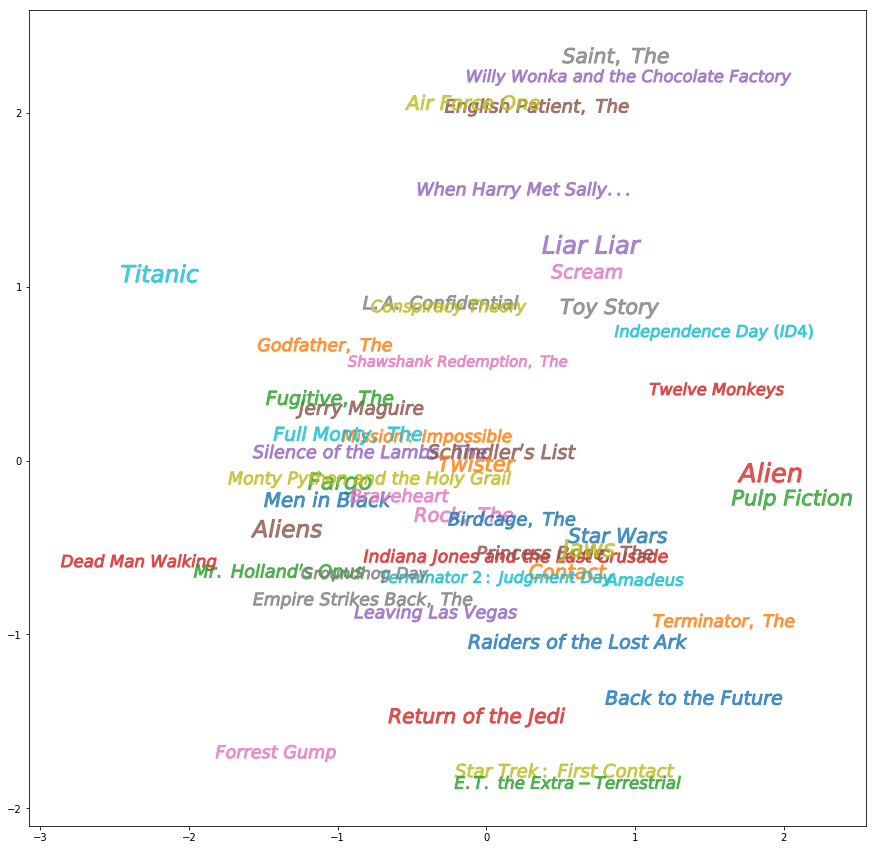

In [45]:
plt.figure(figsize=(15,15))
markers = ["$ {} $".format("\ ".join(m.split(" ")[:-1])) for m in top50["movie_title"]]
for i,item in enumerate(factors):
    l = len(markers[i])
    plt.scatter(item[0], item[1], marker = markers[i], alpha=0.75, s = 50 * (l**2))
plt.show()

In [46]:
svd100.b_i.shape

(1683,)

In [47]:
movie_stats.assign(bias = svd100.b_i[:-1]).sort_values("bias", ascending=False)[:25]

,movie_title,num_ratings,avg_rating,bias
movie_id,,,,
319,Everyone Says I Love You (1996),168,3.273810,1.138518
409,Jack (1996),70,3.142857,1.112434
484,"Maltese Falcon, The (1941)",138,4.210145,1.067097
170,Cinema Paradiso (1988),121,4.173554,1.065820
65,What's Eating Gilbert Grape (1993),115,3.539130,1.037628
13,Mighty Aphrodite (1995),184,3.418478,1.017630
604,It Happened One Night (1934),81,4.012346,1.003792
179,"Clockwork Orange, A (1971)",221,3.909502,0.985536
99,Snow White and the Seven Dwarfs (1937),172,3.709302,0.964325


# Implementations in `scikit-surprise`

[Surprise](http://surpriselib.com/) contains implementations of many of the same things, so these are tested below. This same dataset is included as a built-in, but for consistency, we may as well load it from our dataframe.

In [48]:
import surprise
from surprise.dataset import Dataset

In [49]:
reader = surprise.Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ml[["user_id", "movie_id", "rating"]], reader)

In [50]:
cv=5
cv_random = surprise.model_selection.cross_validate(surprise.NormalPredictor(), data, cv=cv)

In [51]:
cv_sl1 = surprise.model_selection.cross_validate(surprise.SlopeOne(), data, cv=cv)

In [52]:
cv_svd = surprise.model_selection.cross_validate(surprise.SVD(), data, cv=cv)

# Overall results

In [53]:
get_record = lambda name, df: \
    ("Surprise", name, df["test_mae"].sum() / cv, df["test_rmse"].sum() / cv)
cv_data_surprise = [
    get_record(name,d) for name,d in [("Random", cv_random), ("Slope One", cv_sl1), ("SVD", cv_svd)]
]
pd.DataFrame.from_records(
    data=test_results + cv_data_surprise,
    columns=("Library", "Algorithm", "MAE (test)", "RMSE (test)"),
)

,Library,Algorithm,MAE (test),RMSE (test)
0,,Slope One,0.771501,0.995776
1,,SVD,0.744689,0.944377
2,Surprise,Random,1.223264,1.524242
3,Surprise,Slope One,0.742280,0.944255
4,Surprise,SVD,0.737275,0.935624
